In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, Nadam, RMSprop
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

Using TensorFlow backend.


In [2]:
train = pd.read_csv("train.csv")

In [3]:
test = pd.read_csv("test.csv")

In [4]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [5]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Pernot, Mr. Rene",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


In [6]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]

In [8]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)


In [9]:
for dataset in combine:    
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [10]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)


train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


In [11]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
combine = [train, test]

In [12]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [13]:
guess_ages = numpy.zeros((2,3))
guess_ages

for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


In [14]:
for dataset in combine: 
    age_ave = dataset['Age'].mean()
    dataset['Age'] = dataset['Age'].fillna(age_ave)
    dataset['Age'] = dataset['Age'].fillna(age_ave)
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [15]:
freq_port = train.Embarked.dropna().mode()[0]
freq_port
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    


In [16]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)



In [17]:
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)

for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [18]:
def build_model( length ):
    model = keras.Sequential([
            layers.Dense(16, activation=tf.nn.relu, input_shape=[length]),
            
           # layers.Dense(1 , activation="sigmoid")
            # layers.Dense(32, activation=tf.nn.relu),
           # 
             
             layers.Dense(8,  activation=tf.nn.relu),
             layers.Dense(1,  activation="sigmoid")
        ])
    optimizer = tf.keras.optimizers.Adam(0.001)
    model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy', tf.keras.metrics.AUC()])
    return model

In [19]:
combine = [train, test]

In [20]:

    one_hott = pd.get_dummies(train['Title'], "Title")
    # Drop column B as it is now encoded
    train = train.drop('Title',axis = 1)
    # Join the encoded df
    train = train.join(one_hott)
    
    one_hott = pd.get_dummies(test['Title'], "Title")
    # Drop column B as it is now encoded
    test = test.drop('Title',axis = 1)
    # Join the encoded df
    test = test.join(one_hott)

In [21]:
test


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title_1,Title_2,Title_3,Title_4,Title_5
0,892,3,0,2,0,0,0,2,1,1,1,0,0,0,0
1,893,3,1,2,1,0,0,0,2,0,0,0,1,0,0
2,894,2,0,3,0,0,1,2,1,1,1,0,0,0,0
3,895,3,0,1,0,0,1,0,1,1,1,0,0,0,0
4,896,3,1,1,1,1,1,0,3,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,1,0,0,1,0,1,1,1,0,0,0,0
414,1306,1,1,2,0,0,3,1,1,1,0,0,0,0,1
415,1307,3,0,2,0,0,0,0,1,1,1,0,0,0,0
416,1308,3,0,1,0,0,1,0,1,1,1,0,0,0,0


In [22]:

    one_hott = pd.get_dummies(train['Pclass'], "Pclass")
    # Drop column B as it is now encoded
    train = train.drop('Pclass',axis = 1)
    # Join the encoded df
    train = train.join(one_hott)
    one_hott = pd.get_dummies(test['Pclass'], "Pclass")
    # Drop column B as it is now encoded
    test = test.drop('Pclass',axis = 1)
    # Join the encoded df
    test = test.join(one_hott)

In [23]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=200)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, shuffle=True, random_state=111)
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

    

In [24]:
 def valmodel(datan):
    cvscores = []
    ttest_predictions =[]
    ttest_labels = []

    tame = 0
    same = 0
    plott = pd.DataFrame()
    for train, test in kfold.split(datan):
       
        train_dataset = datan.iloc[train]
        test_dataset = datan.iloc[test]

        
        
        train_labels = train_dataset.pop('Survived')
        train_stats = train_dataset.describe()
    
        train_stats = train_stats.transpose()
    
        test_labels = test_dataset.pop('Survived')
       # normed_train_data = norm(train_dataset, train_stats )
       # normed_test_data = norm(test_dataset, train_stats)
       
        model = build_model(len(train_dataset.keys()))
        history = model.fit(train_dataset, train_labels, epochs=10000,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
    
        plot_history(history)
        loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)
        test_predictions = model.predict(test_dataset).flatten()
        tame = tame + mae
        same = same + mse
       
        ttest_labels = ttest_labels + (test_labels.values.tolist())
        ttest_predictions = ttest_predictions + (test_predictions.tolist())

        
    plott['label'] = ttest_labels

   
    plott['pre'] = ttest_predictions
    plott['resid'] = -(plott['label'] - plott['pre'])

    plott['MAE'] = tame / 10
    plott['MSE']= same / 10
    
    
    
    return plott

In [25]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error ')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
          label = 'Val Error')
  plt.show()

W0129 15:09:43.107018 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
.......

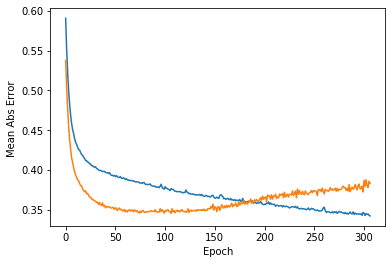

W0129 15:09:55.223650 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:09:55.234622 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:09:55.500908 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.........

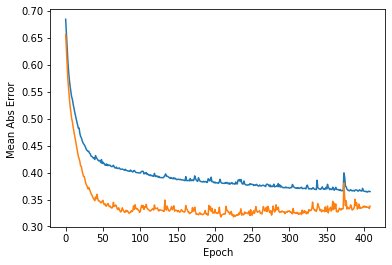

W0129 15:10:12.048709 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:12.054693 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:12.359877 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
......

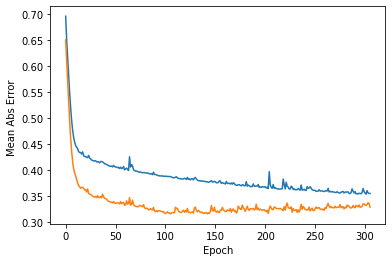

W0129 15:10:24.275013 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:24.287978 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:24.629066 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
..........................................

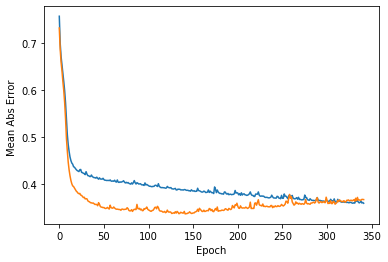

W0129 15:10:37.683184 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:37.690165 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:37.917557 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............................................................................................

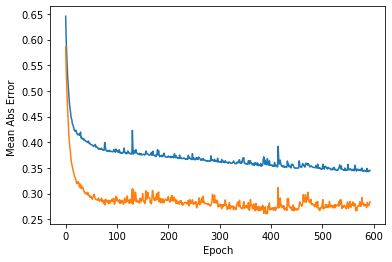

W0129 15:10:56.477279 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:56.483262 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:10:56.691744 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
..................................................

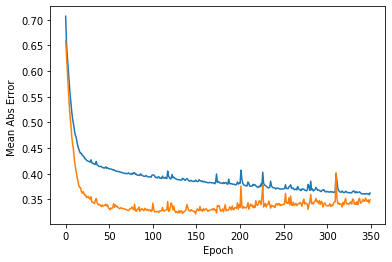

W0129 15:11:08.652827 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:08.661767 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:08.876194 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
..................................................................................................

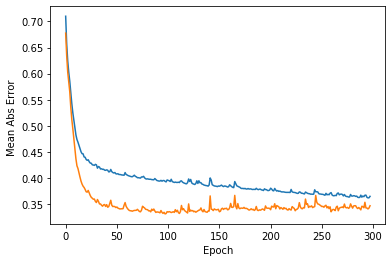

W0129 15:11:19.029043 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:19.037022 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:19.289347 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.....................................................................

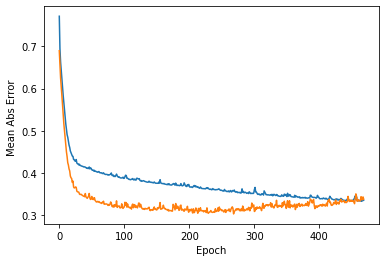

W0129 15:11:35.877998 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:35.884999 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:36.089452 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
.................................................

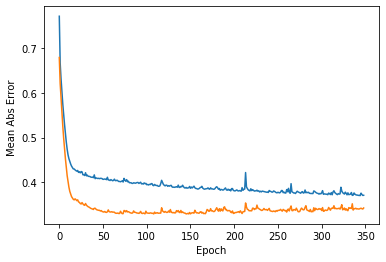

W0129 15:11:47.829120 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:47.835144 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:48.037597 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
..................

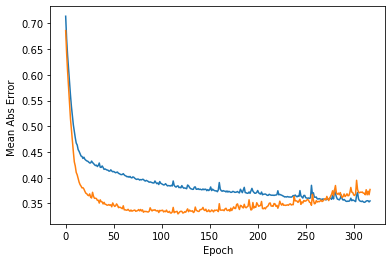

W0129 15:11:59.041135 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>
W0129 15:11:59.047119 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


In [26]:
lpf = valmodel(train)

In [27]:
tr = pd.DataFrame()
tr["Survived"] = lpf['pre']
tr["label"] = lpf['label']
tr.loc[tr["Survived"] >= .6, "Survived"] = 1 
tr.loc[tr["Survived"] < .6, "Survived"] = 0 

a = tf.math.confusion_matrix(lpf['label'], tr["Survived"])
(a[0][1] + a[1][0]) / (a[1][1] + a[0][0])

<tf.Tensor: id=639032, shape=(), dtype=float64, numpy=0.23922114047287898>

In [28]:
tr = pd.DataFrame()
tr["Survived"] = lpf['pre']
tr["label"] = lpf['label']
tr.loc[tr["Survived"] >= .63, "Survived"] = 1 
tr.loc[tr["Survived"] < .63, "Survived"] = 0 

a = tf.math.confusion_matrix(lpf['label'], tr["Survived"])
(a[0][1] + a[1][0]) / (a[1][1] + a[0][0])

<tf.Tensor: id=639097, shape=(), dtype=float64, numpy=0.24441340782122906>

In [29]:
tr = pd.DataFrame()
tr["Survived"] =lpf['pre']
tr.loc[tr["Survived"] >= .7, "Survived"] = 1 
tr.loc[tr["Survived"] < .7, "Survived"] = 0 

a = tf.math.confusion_matrix(lpf['label'], tr["Survived"])
(a[0][1] + a[1][0]) / (a[1][1] + a[0][0])


<tf.Tensor: id=639162, shape=(), dtype=float64, numpy=0.22727272727272727>

In [30]:

train_labels = train.pop('Survived')

In [31]:

model = build_model(len(train.keys()))
history = model.fit(train, train_labels, epochs=10000,
                        validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

W0129 15:11:59.402204 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>



....................................................................................................
....................................................................................................
....................................................................................................
................................................................

In [32]:
 test_labels = test.pop('PassengerId')

In [33]:
test


,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title_1,Title_2,Title_3,Title_4,Title_5,Pclass_1,Pclass_2,Pclass_3
0,0,2,0,0,0,2,1,1,1,0,0,0,0,0,0,1
1,1,2,1,0,0,0,2,0,0,0,1,0,0,0,0,1
2,0,3,0,0,1,2,1,1,1,0,0,0,0,0,1,0
3,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1
4,1,1,1,1,1,0,3,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1
414,1,2,0,0,3,1,1,1,0,0,0,0,1,1,0,0
415,0,2,0,0,0,0,1,1,1,0,0,0,0,0,0,1
416,0,1,0,0,1,0,1,1,1,0,0,0,0,0,0,1


In [34]:
test_predictions = model.predict(test).flatten()

W0129 15:12:12.438311 36648 training.py:504] Falling back from v2 loop because of error: Failed to find data adapter that can handle input: <class 'pandas.core.frame.DataFrame'>, <class 'NoneType'>


In [35]:
result2 = pd.DataFrame()

In [36]:
result2["PassengerId"] = test_labels

In [37]:
result2

,PassengerId
0,892
1,893
2,894
3,895
4,896
...,...
413,1305
414,1306
415,1307
416,1308


In [38]:
result2["Survived"] =test_predictions

In [39]:
result2.loc[result2["Survived"] >= .61, "Survived"] = 1 
result2.loc[result2["Survived"] < .61, "Survived"] = 0 

In [40]:
result2.Survived = result2.Survived.astype(int)

In [41]:
result2.to_csv(r'C:\\Users\\BCI034\\Desktop\\result.csv',index=False)